### Volume Profiles

Informing trades based on areas of high/low volume

[*********************100%%**********************]  1 of 1 completed


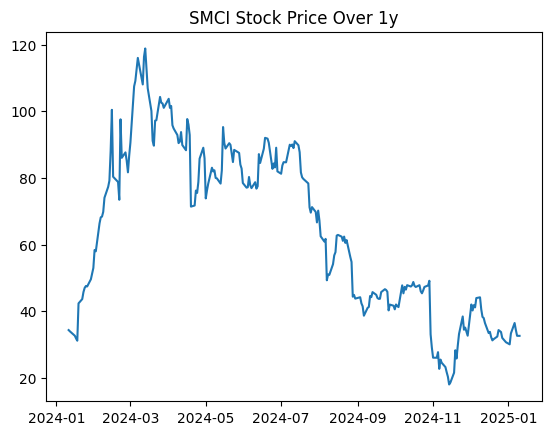

In [165]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import plotly.express as px
import plotly.graph_objects as go
import yfinance as yf
import matplotlib.pyplot as plt

symbol = "SMCI"
period = "1y"
data = yf.download(symbol, period = period)

df = data.reset_index()
volume = df['Volume']
close = df['Close']

plt.plot(df['Date'], df['Close'])
plt.title('{} Stock Price Over {}'.format(symbol, period))
plt.show()

In [166]:
fig = px.histogram(df, x = 'Volume', y = 'Close', nbins = 150, orientation = 'h')
fig.update_layout(title = '{} Volume Profile on {} Timeframe'.format(symbol, period))
fig.show()

This graph does the job, but is rough and highly dependent on how many bins are defined. Let's smoothen it out.

A kernel density estimator (KDE) is a non-parametric way to estimate the probability density function (PDF) of a random variable. This allows us to represent our distribution as a smooth and continuous curve.

We’ll use SciPy’s gaussian_kde to get our PDF. We can plot a normalized histogram with the curve to see how it fits.

In [167]:
kde_factor = 0.05
num_samples = 500
kde = stats.gaussian_kde(close,weights=volume,bw_method=kde_factor)
xr = np.linspace(close.min(),close.max(),num_samples)
kdy = kde(xr)
ticks_per_sample = (xr.max() - xr.min()) / num_samples

def get_dist_plot(c, v, kx, ky):
    fig = go.Figure()
    fig.add_trace(go.Histogram(name='Vol Profile', x=c, y=v, nbinsx=150, 
                               histfunc='sum', histnorm='probability density',
                               marker_color='#B0C4DE'))
    fig.add_trace(go.Scatter(name='KDE', x=kx, y=ky, mode='lines', marker_color='#D2691E'))
    return fig

get_dist_plot(close, volume, xr, kdy).show()

To help us determine the structure of our volume profile, we use find_peaks from SciPy’s signal processing module.

In [168]:
peaks,_ = signal.find_peaks(kdy)
pkx = xr[peaks]
pky = kdy[peaks]

pk_marker_args=dict(size=10)
fig = get_dist_plot(close, volume, xr, kdy)
fig.add_trace(go.Scatter(name="Peaks", x=pkx, y=pky, mode='markers', marker=pk_marker_args))

### Further Refine:
https://medium.com/swlh/how-to-analyze-volume-profiles-with-python-3166bb10ff24

* Prominence

In [169]:
# This is where we could dynamically split the df based on date (take only data after dateX)
dfpl = df

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'])])

fig.update_layout(
    autosize=False,
    width=1000,
    height=800, 
    paper_bgcolor='black',
    plot_bgcolor='black')
fig.update_xaxes(gridcolor='black')
fig.update_yaxes(gridcolor='black')

for peak in pkx:
    fig.add_hline(y = peak)

# ideal_bins = max(df['Close']) - min(df['Close']) / 20 # each bin is 5% of total range of price action
# fig.add_histogram(df, x = 'Volume', y = 'Close', nbins = ideal_bins, orientation = 'h')

fig.show()